In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error 
from math import sqrt 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, adfuller
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.arima_model import ARIMA

In [2]:
train = pd.read_csv('./TrainData.csv')
test = pd.read_csv('./TestData.csv')

In [3]:
train.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [4]:
test.isnull().sum()

ID          0
Datetime    0
dtype: int64

In [5]:
rcParams['figure.figsize'] = 15, 10

In [6]:
train_org = train.copy()
test_org = test.copy()

In [7]:
train.columns

Index(['ID', 'Datetime', 'Count'], dtype='object')

In [8]:
test.columns

Index(['ID', 'Datetime'], dtype='object')

In [9]:
print(train.shape)
test.shape

(18288, 3)


(5112, 2)

In [10]:
train.Datetime.head(10)

0    25-08-2012 00:00
1    25-08-2012 01:00
2    25-08-2012 02:00
3    25-08-2012 03:00
4    25-08-2012 04:00
5    25-08-2012 05:00
6    25-08-2012 06:00
7    25-08-2012 07:00
8    25-08-2012 08:00
9    25-08-2012 09:00
Name: Datetime, dtype: object

In [11]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test_org['Datetime'] = pd.to_datetime(test_org.Datetime,format='%d-%m-%Y %H:%M')
train_org['Datetime'] = pd.to_datetime(train_org.Datetime,format='%d-%m-%Y %H:%M')

In [12]:
train.Datetime.head(10)

0   2012-08-25 00:00:00
1   2012-08-25 01:00:00
2   2012-08-25 02:00:00
3   2012-08-25 03:00:00
4   2012-08-25 04:00:00
5   2012-08-25 05:00:00
6   2012-08-25 06:00:00
7   2012-08-25 07:00:00
8   2012-08-25 08:00:00
9   2012-08-25 09:00:00
Name: Datetime, dtype: datetime64[ns]

In [13]:
for i in (train,test):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [14]:
train['dayOfWeek'] = train['Datetime'].dt.dayofweek

In [15]:
train.head(25)

,ID,Datetime,Count,year,month,day,Hour,dayOfWeek
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5
5,5,2012-08-25 05:00:00,2,2012,8,25,5,5
6,6,2012-08-25 06:00:00,2,2012,8,25,6,5
7,7,2012-08-25 07:00:00,2,2012,8,25,7,5
8,8,2012-08-25 08:00:00,6,2012,8,25,8,5
9,9,2012-08-25 09:00:00,2,2012,8,25,9,5


In [16]:
def weekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 

In [17]:
train['weekend'] = train.Datetime.apply(weekend)

In [18]:
train.head(100)

,ID,Datetime,Count,year,month,day,Hour,dayOfWeek,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1
5,5,2012-08-25 05:00:00,2,2012,8,25,5,5,1
6,6,2012-08-25 06:00:00,2,2012,8,25,6,5,1
7,7,2012-08-25 07:00:00,2,2012,8,25,7,5,1
8,8,2012-08-25 08:00:00,6,2012,8,25,8,5,1
9,9,2012-08-25 09:00:00,2,2012,8,25,9,5,1


In [19]:
train.set_index('Datetime',inplace=True)
train.drop('ID',axis=1,inplace=True)

In [20]:
train.head(25)

,Count,year,month,day,Hour,dayOfWeek,weekend
Datetime,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2,2012,8,25,4,5,1
2012-08-25 05:00:00,2,2012,8,25,5,5,1
2012-08-25 06:00:00,2,2012,8,25,6,5,1
2012-08-25 07:00:00,2,2012,8,25,7,5,1
2012-08-25 08:00:00,6,2012,8,25,8,5,1


## Plotting the time series

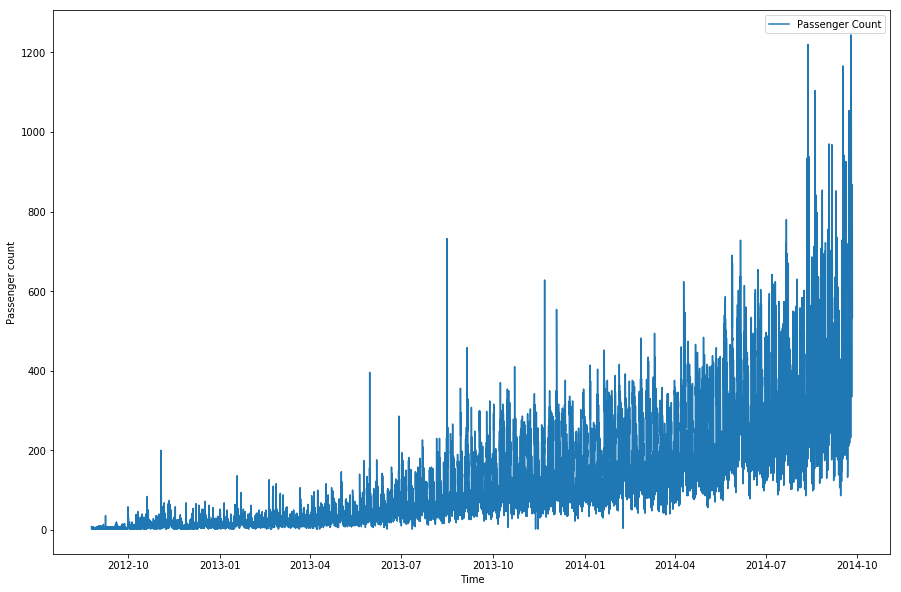

In [22]:
plt.plot(train['Count'],label = 'Passenger Count')
plt.xlabel("Time") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

## Visualising Trends

## 1. YearWise

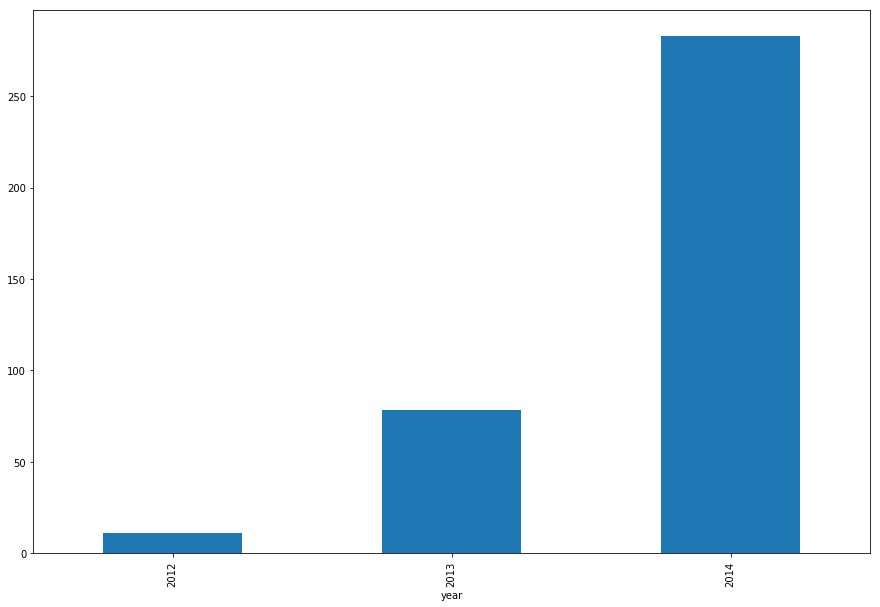

In [23]:
train.groupby('year')['Count'].mean().plot.bar()

## 2. MonthWise

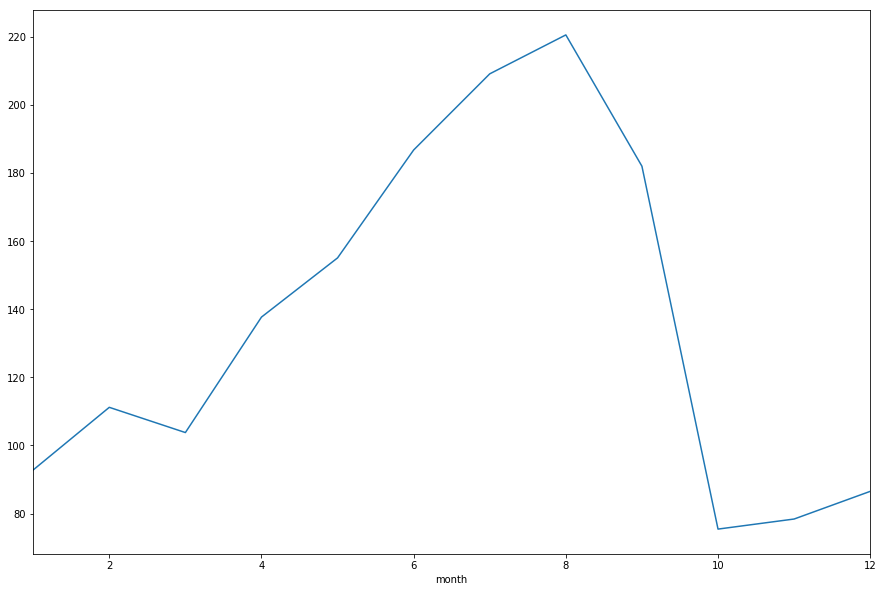

In [24]:
train.groupby('month')['Count'].mean().plot()

## Year+Month wise

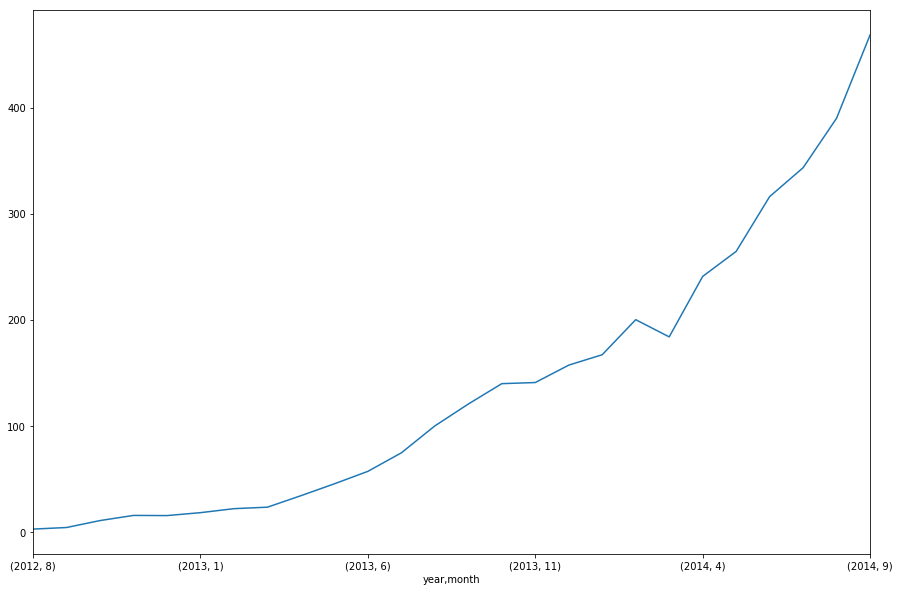

In [25]:
train.groupby(['year','month'])['Count'].mean().plot()

## 3. Hour Wise

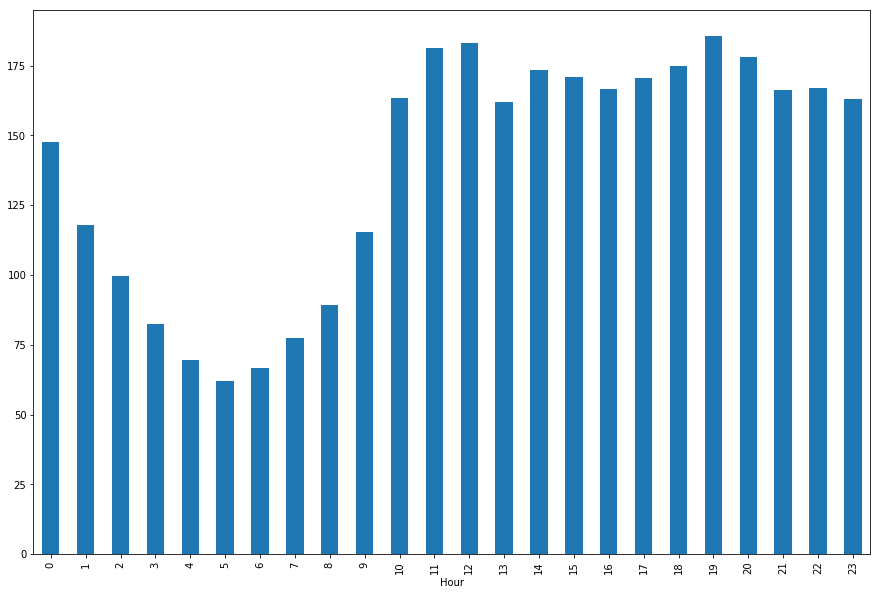

In [26]:
train.groupby('Hour')['Count'].mean().plot.bar()

## 4. Daywise for the weekends

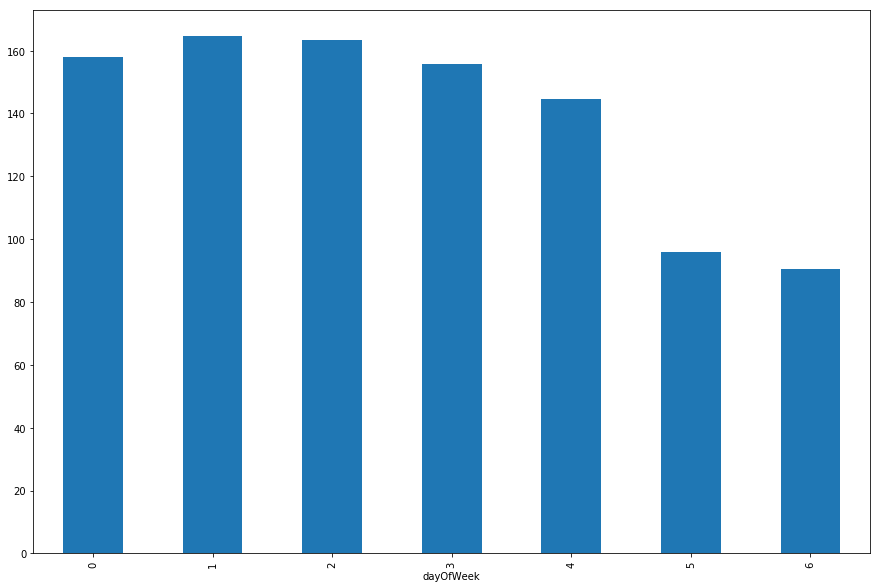

In [27]:
train.groupby('dayOfWeek')['Count'].mean().plot.bar()

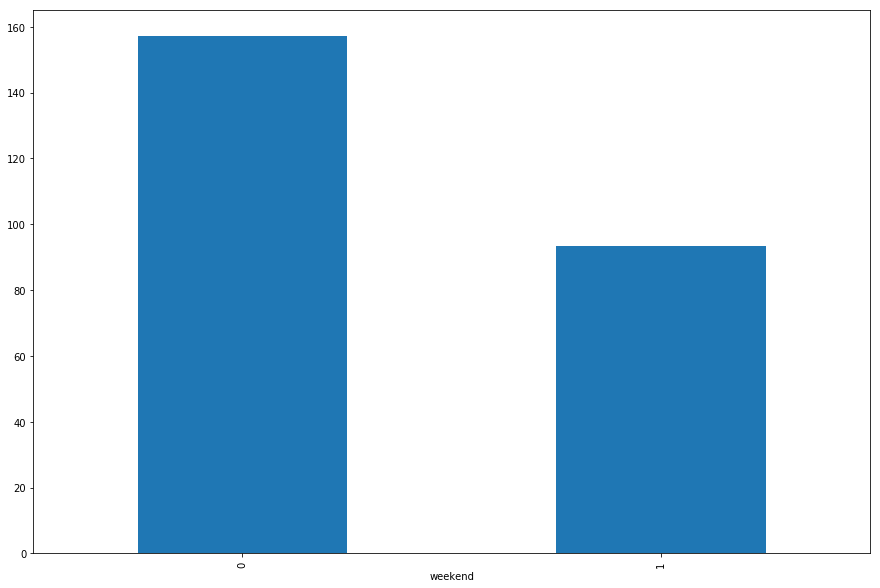

In [28]:
train.groupby('weekend')['Count'].mean().plot.bar()

## Resampling data

In [29]:
hourly = train.resample('H').mean() 
daily = train.resample('D').mean()  
weekly = train.resample('W').mean() 
monthly = train.resample('M').mean()

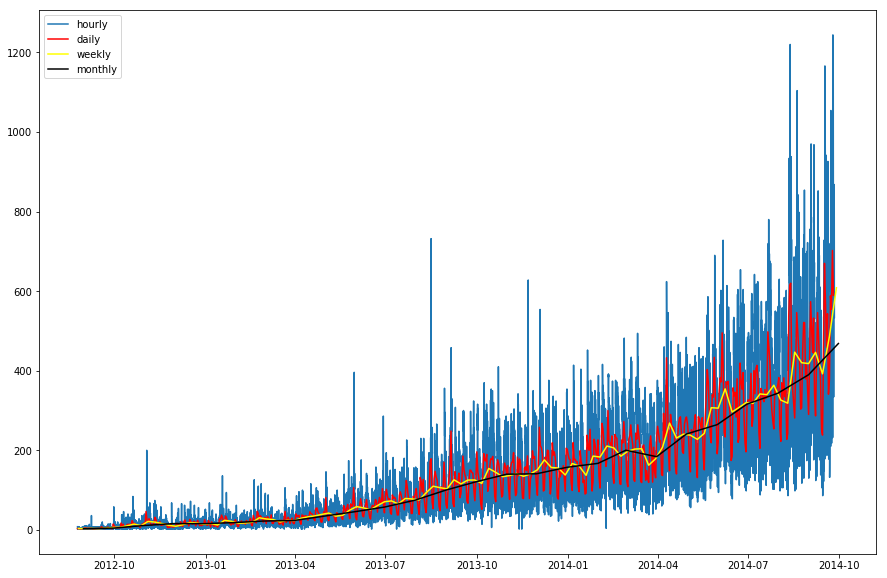

In [30]:
plt.plot(hourly['Count'])
plt.plot(daily['Count'],color='red')
plt.plot(weekly['Count'],color='yellow')
plt.plot(monthly['Count'],color='black')
plt.legend(['hourly','daily','weekly','monthly'])

## Resampling the entire data to daily basis

In [31]:
train = train.resample('D').mean()

In [32]:
test.set_index('Datetime',inplace=True)
test.drop('ID',axis=1,inplace=True)

In [33]:
test = test.resample('D').mean()

## Splitting train data to form validation data

### Total : 25 Months
### Train : 22 Months
### Valid : 3 Months

In [34]:
training=train.loc['2012-08-25':'2014-06-24'] 
validating=train.loc['2014-06-25':'2014-09-25']

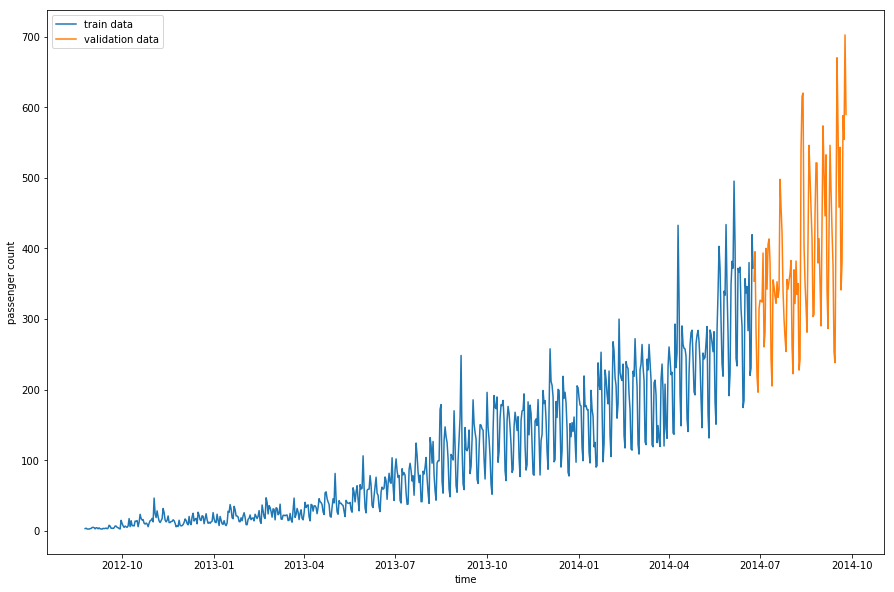

In [35]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data'])

# Forecasting and validating

In [36]:
arr = np.asarray(training.Count)

In [37]:
pred = validating.copy()

## Naive Prediction

In [38]:
pred['naive'] = arr[arr.shape[0]-1]

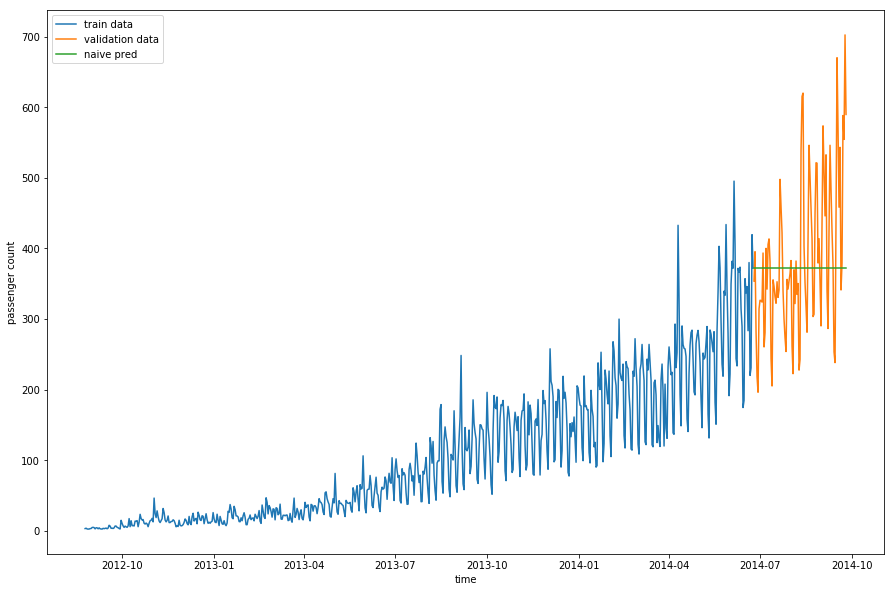

In [39]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['naive'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','naive pred'])

In [40]:
rms = sqrt(mean_squared_error(validating.Count, pred.naive)) 
print("RMS SCORE:",rms)

RMS SCORE: 111.79050467496724


## Moving Averages Forecasting

In [41]:
pred['MAF'] = training['Count'].rolling(25).mean().iloc[-1]

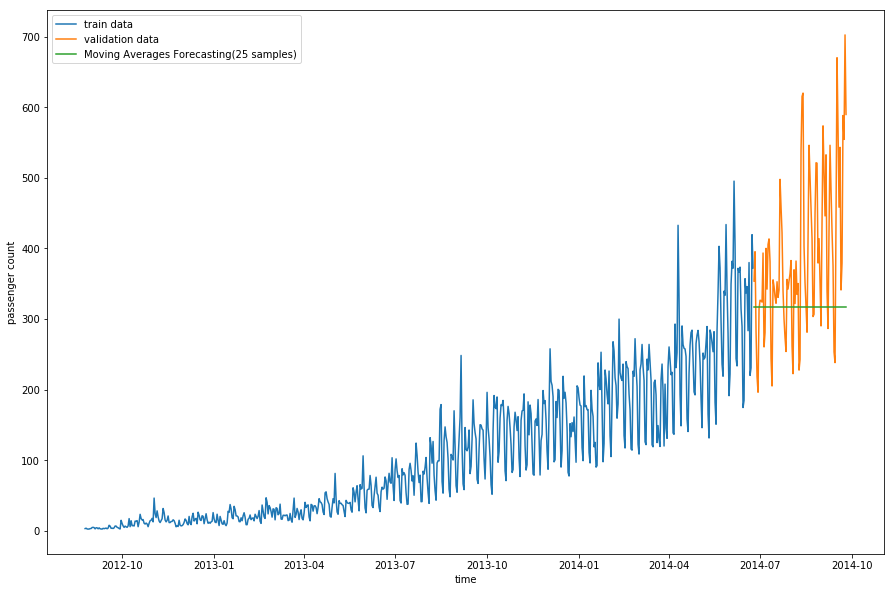

In [42]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['MAF'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','Moving Averages Forecasting(25 samples)'])

In [41]:
rms = sqrt(mean_squared_error(validating.Count, pred.MAF)) 
print("RMS SCORE:",rms)

RMS SCORE: 132.25462585292883


## Exponential Smoothening

In [43]:
pred['ES'] = SimpleExpSmoothing(np.asarray(training['Count'])).fit(smoothing_level=0.6,optimized=False).forecast(
                len(validating))

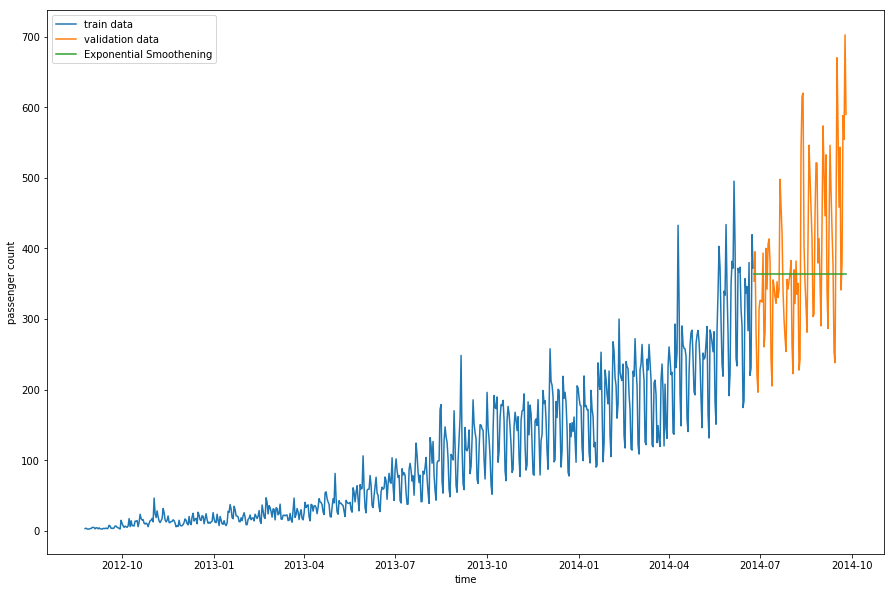

In [44]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['ES'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','Exponential Smoothening'])

In [169]:
rms = sqrt(mean_squared_error(validating.Count, pred.ES)) 
print("RMS SCORE:",rms)

RMS SCORE: 113.43708111884514


## Holt's Linear Forecasting

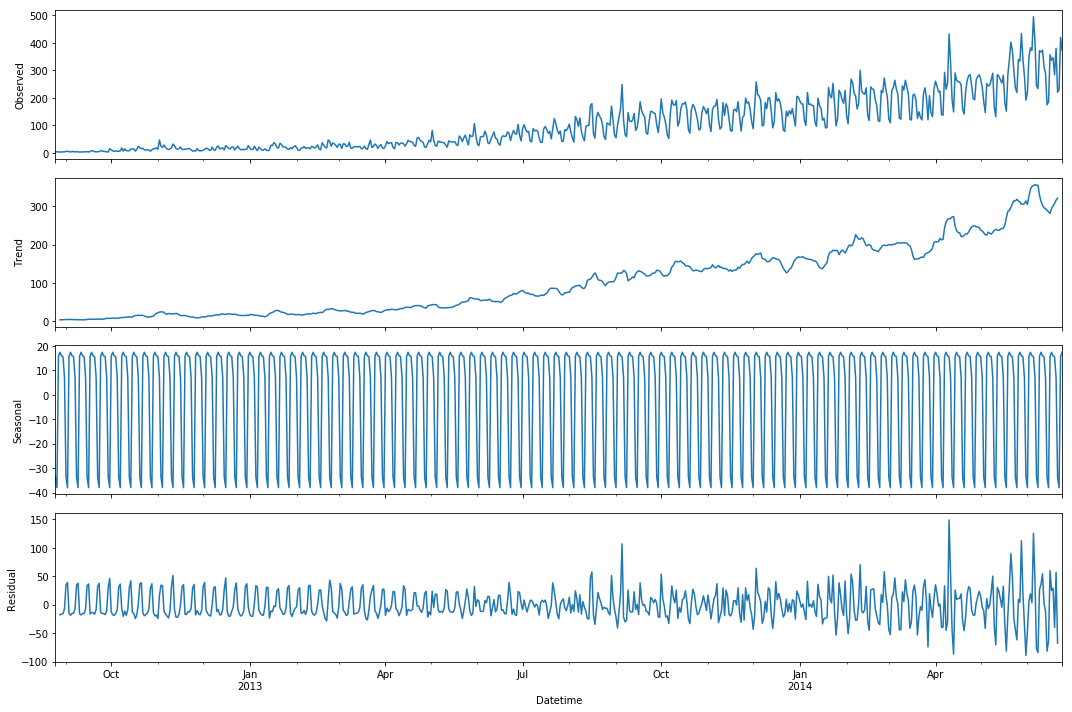

In [45]:
sm.tsa.seasonal_decompose(training.Count).plot() 
result = sm.tsa.stattools.adfuller(training.Count) 
plt.show()

In [46]:
pred['HLF'] = Holt(arr).fit(smoothing_level = 0.3,smoothing_slope = 0.1).forecast(len(validating))

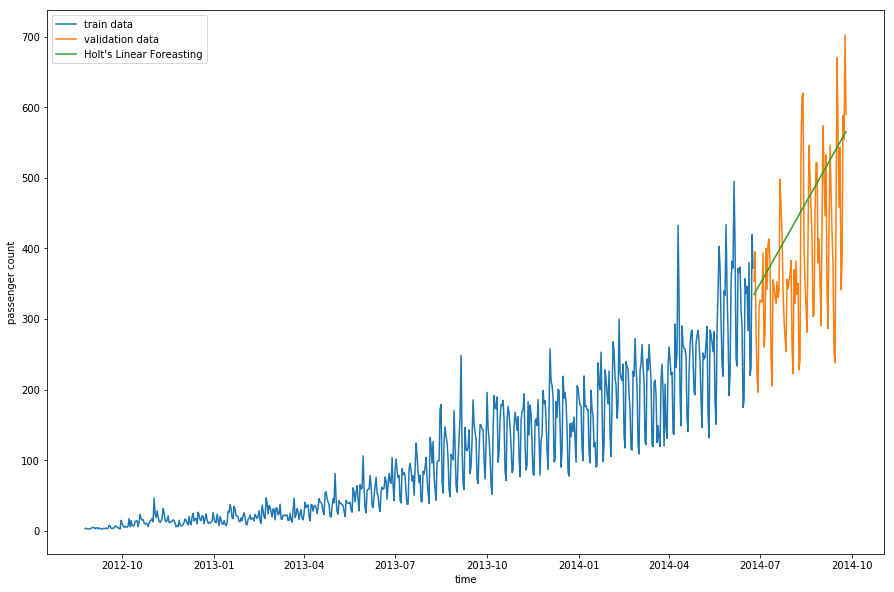

In [47]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['HLF'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data',"Holt's Linear Foreasting"])

In [48]:
rms = sqrt(mean_squared_error(validating.Count, pred.HLF)) 
print("RMS SCORE:",rms)

RMS SCORE: 112.94278345314041


## Holt's Winter Forecasting

In [49]:
model = ExponentialSmoothing(arr,seasonal_periods=7 ,trend='add', seasonal='add').fit()
pred['HWF'] = model.forecast(len(validating))

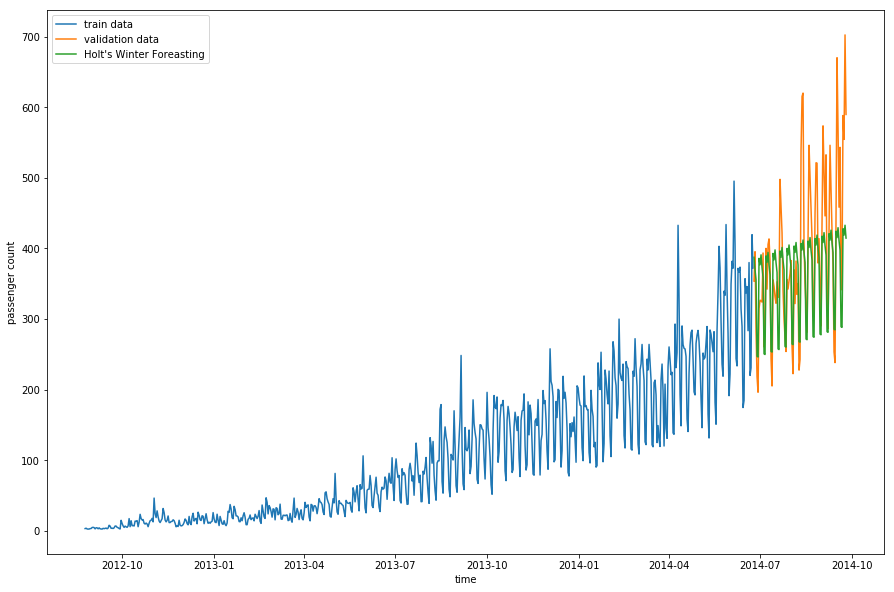

In [50]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['HWF'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data',"Holt's Winter Foreasting"])

In [51]:
rms = sqrt(mean_squared_error(validating.Count, pred.HWF)) 
print("RMS SCORE:",rms)

RMS SCORE: 82.37571191747172


## Since HWF is giving much better RMSE score, let's forecast on test data

In [52]:
test['pred_HWF'] = model.forecast(len(test)) 

In [53]:
test.head(10)

,year,month,day,Hour,pred_HWF
Datetime,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,387.359995
2014-09-27,2014.0,9.0,27.0,11.5,369.135921
2014-09-28,2014.0,9.0,28.0,11.5,355.563302
2014-09-29,2014.0,9.0,29.0,11.5,247.088754
2014-09-30,2014.0,9.0,30.0,11.5,246.192644
2014-10-01,2014.0,10.0,1.0,11.5,385.879030
2014-10-02,2014.0,10.0,2.0,11.5,376.801695
2014-10-03,2014.0,10.0,3.0,11.5,390.854011
2014-10-04,2014.0,10.0,4.0,11.5,372.629937


In [54]:
test_org.head(10)

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00
5,18293,2014-09-26 05:00:00
6,18294,2014-09-26 06:00:00
7,18295,2014-09-26 07:00:00
8,18296,2014-09-26 08:00:00
9,18297,2014-09-26 09:00:00


In [55]:
train_org.head(10)

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2
5,5,2012-08-25 05:00:00,2
6,6,2012-08-25 06:00:00,2
7,7,2012-08-25 07:00:00,2
8,8,2012-08-25 08:00:00,6
9,9,2012-08-25 09:00:00,2


## Since we sampled the data on daily basis while test data demands forecasting on hourly basis, let's find the count ratio of each hour of everyday on train data

In [56]:
train_org['ratio']=train_org['Count']/train_org['Count'].sum()

In [57]:
train_org.head(10)

,ID,Datetime,Count,ratio
0,0,2012-08-25 00:00:00,8,3.148037e-06
1,1,2012-08-25 01:00:00,2,7.870093e-07
2,2,2012-08-25 02:00:00,6,2.361028e-06
3,3,2012-08-25 03:00:00,2,7.870093e-07
4,4,2012-08-25 04:00:00,2,7.870093e-07
5,5,2012-08-25 05:00:00,2,7.870093e-07
6,6,2012-08-25 06:00:00,2,7.870093e-07
7,7,2012-08-25 07:00:00,2,7.870093e-07
8,8,2012-08-25 08:00:00,6,2.361028e-06
9,9,2012-08-25 09:00:00,2,7.870093e-07


In [58]:
train_org.dtypes

ID                   int64
Datetime    datetime64[ns]
Count                int64
ratio              float64
dtype: object

In [59]:
for i in (train_org,test_org):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [60]:
train_org.head(24)

,ID,Datetime,Count,ratio,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,3.148037e-06,2012,8,25,0
1,1,2012-08-25 01:00:00,2,7.870093e-07,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2.361028e-06,2012,8,25,2
3,3,2012-08-25 03:00:00,2,7.870093e-07,2012,8,25,3
4,4,2012-08-25 04:00:00,2,7.870093e-07,2012,8,25,4
5,5,2012-08-25 05:00:00,2,7.870093e-07,2012,8,25,5
6,6,2012-08-25 06:00:00,2,7.870093e-07,2012,8,25,6
7,7,2012-08-25 07:00:00,2,7.870093e-07,2012,8,25,7
8,8,2012-08-25 08:00:00,6,2.361028e-06,2012,8,25,8
9,9,2012-08-25 09:00:00,2,7.870093e-07,2012,8,25,9


## After getting the required ratios, let's club them together so that we can get a ratio for each hour over the entire train data.

In [61]:
groupbydf = pd.DataFrame(train_org.groupby('Hour')['ratio'].sum())

In [62]:
groupbydf

,ratio
Hour,
0,0.044287
1,0.035343
2,0.029911
3,0.024714
4,0.020802
5,0.018621
6,0.020023
7,0.023221
8,0.026741


## Doing necessary operations required to make foreacsting feasible on test data

In [63]:
finalTestPred = pd.merge(test, test_org, on=('day','month', 'year'), how='left')

In [64]:
finalTestPred.head(10)

,year,month,day,Hour_x,pred_HWF,ID,Datetime,Hour_y
0,2014.0,9.0,26.0,11.5,387.359995,18288,2014-09-26 00:00:00,0
1,2014.0,9.0,26.0,11.5,387.359995,18289,2014-09-26 01:00:00,1
2,2014.0,9.0,26.0,11.5,387.359995,18290,2014-09-26 02:00:00,2
3,2014.0,9.0,26.0,11.5,387.359995,18291,2014-09-26 03:00:00,3
4,2014.0,9.0,26.0,11.5,387.359995,18292,2014-09-26 04:00:00,4
5,2014.0,9.0,26.0,11.5,387.359995,18293,2014-09-26 05:00:00,5
6,2014.0,9.0,26.0,11.5,387.359995,18294,2014-09-26 06:00:00,6
7,2014.0,9.0,26.0,11.5,387.359995,18295,2014-09-26 07:00:00,7
8,2014.0,9.0,26.0,11.5,387.359995,18296,2014-09-26 08:00:00,8
9,2014.0,9.0,26.0,11.5,387.359995,18297,2014-09-26 09:00:00,9


In [65]:
finalTestPred['Hour'] = finalTestPred['Hour_y']

In [66]:
finalTestPred.head(10)

,year,month,day,Hour_x,pred_HWF,ID,Datetime,Hour_y,Hour
0,2014.0,9.0,26.0,11.5,387.359995,18288,2014-09-26 00:00:00,0,0
1,2014.0,9.0,26.0,11.5,387.359995,18289,2014-09-26 01:00:00,1,1
2,2014.0,9.0,26.0,11.5,387.359995,18290,2014-09-26 02:00:00,2,2
3,2014.0,9.0,26.0,11.5,387.359995,18291,2014-09-26 03:00:00,3,3
4,2014.0,9.0,26.0,11.5,387.359995,18292,2014-09-26 04:00:00,4,4
5,2014.0,9.0,26.0,11.5,387.359995,18293,2014-09-26 05:00:00,5,5
6,2014.0,9.0,26.0,11.5,387.359995,18294,2014-09-26 06:00:00,6,6
7,2014.0,9.0,26.0,11.5,387.359995,18295,2014-09-26 07:00:00,7,7
8,2014.0,9.0,26.0,11.5,387.359995,18296,2014-09-26 08:00:00,8,8
9,2014.0,9.0,26.0,11.5,387.359995,18297,2014-09-26 09:00:00,9,9


In [67]:
finalTestPred=finalTestPred.drop(['year', 'month','Hour_x','Hour_y'], axis=1) 

In [68]:
finalTestPred.head(10)

,day,pred_HWF,ID,Datetime,Hour
0,26.0,387.359995,18288,2014-09-26 00:00:00,0
1,26.0,387.359995,18289,2014-09-26 01:00:00,1
2,26.0,387.359995,18290,2014-09-26 02:00:00,2
3,26.0,387.359995,18291,2014-09-26 03:00:00,3
4,26.0,387.359995,18292,2014-09-26 04:00:00,4
5,26.0,387.359995,18293,2014-09-26 05:00:00,5
6,26.0,387.359995,18294,2014-09-26 06:00:00,6
7,26.0,387.359995,18295,2014-09-26 07:00:00,7
8,26.0,387.359995,18296,2014-09-26 08:00:00,8
9,26.0,387.359995,18297,2014-09-26 09:00:00,9


In [69]:
finalTestPred = pd.merge(finalTestPred,groupbydf,on='Hour',how='left')

In [70]:
finalTestPred.head(10)

,day,pred_HWF,ID,Datetime,Hour,ratio
0,26.0,387.359995,18288,2014-09-26 00:00:00,0,0.044287
1,26.0,387.359995,18289,2014-09-26 01:00:00,1,0.035343
2,26.0,387.359995,18290,2014-09-26 02:00:00,2,0.029911
3,26.0,387.359995,18291,2014-09-26 03:00:00,3,0.024714
4,26.0,387.359995,18292,2014-09-26 04:00:00,4,0.020802
5,26.0,387.359995,18293,2014-09-26 05:00:00,5,0.018621
6,26.0,387.359995,18294,2014-09-26 06:00:00,6,0.020023
7,26.0,387.359995,18295,2014-09-26 07:00:00,7,0.023221
8,26.0,387.359995,18296,2014-09-26 08:00:00,8,0.026741
9,26.0,387.359995,18297,2014-09-26 09:00:00,9,0.034555


## Finally we multiply the daily count results which are same for every hour for a particular day with the hourly count ratio 

In [71]:
finalTestPred['Count'] = finalTestPred['pred_HWF']*finalTestPred['ratio']*24

In [72]:
finalTestPred.head(10)

,day,pred_HWF,ID,Datetime,Hour,ratio,Count
0,26.0,387.359995,18288,2014-09-26 00:00:00,0,0.044287,411.716459
1,26.0,387.359995,18289,2014-09-26 01:00:00,1,0.035343,328.571274
2,26.0,387.359995,18290,2014-09-26 02:00:00,2,0.029911,278.072500
3,26.0,387.359995,18291,2014-09-26 03:00:00,3,0.024714,229.761373
4,26.0,387.359995,18292,2014-09-26 04:00:00,4,0.020802,193.390842
5,26.0,387.359995,18293,2014-09-26 05:00:00,5,0.018621,173.116703
6,26.0,387.359995,18294,2014-09-26 06:00:00,6,0.020023,186.147465
7,26.0,387.359995,18295,2014-09-26 07:00:00,7,0.023221,215.881892
8,26.0,387.359995,18296,2014-09-26 08:00:00,8,0.026741,248.601468
9,26.0,387.359995,18297,2014-09-26 09:00:00,9,0.034555,321.247415


In [73]:
finalTestPred.drop(['day','pred_HWF','Hour','ratio'],axis=1,inplace=True)

## Final Predictions

In [74]:
finalTestPred

,ID,Datetime,Count
0,18288,2014-09-26 00:00:00,411.716459
1,18289,2014-09-26 01:00:00,328.571274
2,18290,2014-09-26 02:00:00,278.072500
3,18291,2014-09-26 03:00:00,229.761373
4,18292,2014-09-26 04:00:00,193.390842
5,18293,2014-09-26 05:00:00,173.116703
6,18294,2014-09-26 06:00:00,186.147465
7,18295,2014-09-26 07:00:00,215.881892
8,18296,2014-09-26 08:00:00,248.601468
9,18297,2014-09-26 09:00:00,321.247415


## Visualising everything

In [75]:
finalTestPredPlot = finalTestPred.copy()

In [76]:
finalTestPredPlot.set_index('Datetime',inplace=True)
finalTestPredPlot.drop('ID',axis=1,inplace=True)

In [77]:
finalTestPredPlot=finalTestPredPlot.resample('D').mean()

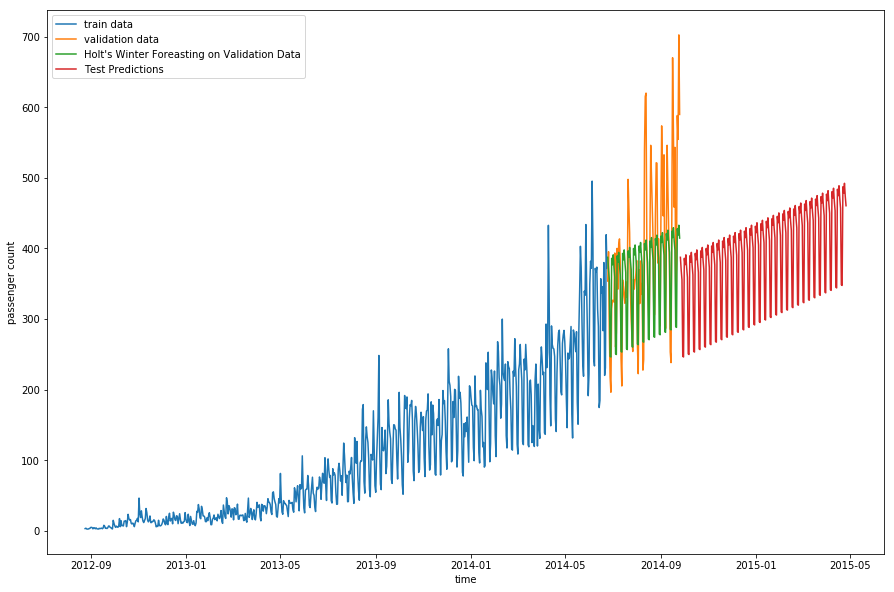

In [78]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['HWF'])
plt.plot(finalTestPredPlot['Count'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data',"Holt's Winter Foreasting on Validation Data",'Test Predictions'])

# ARIMA forecasting

## For ARIMA we need to find the values of p (PACF plot), q (ACF plot) & d (differencing)

## But first we need to check if series is stationary or not, because if it is we need not to find the value of d.

In [79]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [80]:
test_stationarity(train_org['Count'])

Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


## Since test statistic < critical value (1%), series is stationary but weakly because the trend exists as observed in previous plots

## Let's confirm it through ACF plots corresponding to different values of d

## Taking logarithm for removing the trend and making data homoscedastic

In [81]:
train_log = np.log(training['Count'])
valid_log = np.log(validating['Count'])

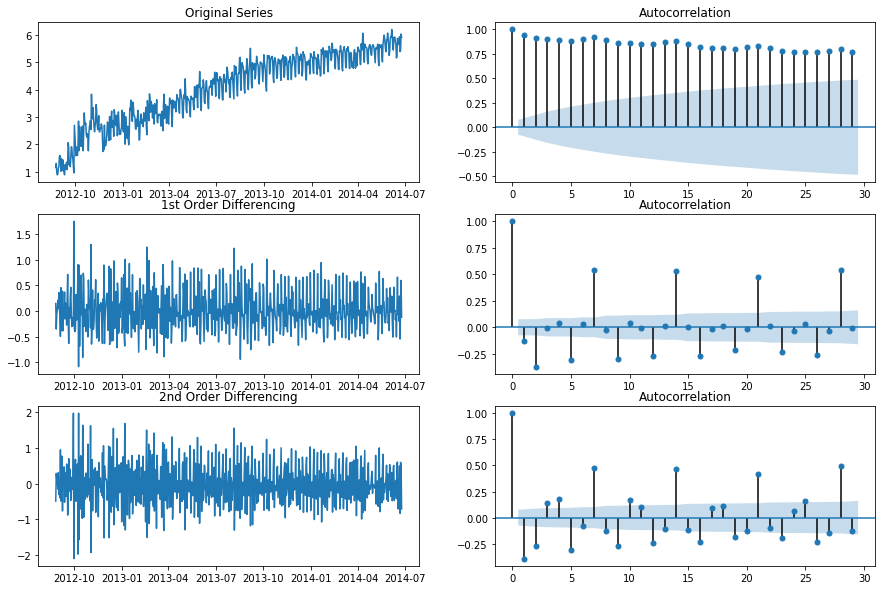

In [83]:
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(train_log)
axes[0, 0].set_title('Original Series')
plot_acf(train_log, ax=axes[0, 1])
axes[1, 0].plot(train_log.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_log.diff().dropna(), ax=axes[1, 1])
axes[2, 0].plot(train_log.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_log.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

In [88]:
test_stationarity(train_log.diff().dropna())

Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


## It can be observed that despite ADF test suggesting TS is stationary, ACF plot does not fall to 0 for original series, hence differencing becomes necessary. We will chose d=1, as d=2 is clearly over-differencing it. 
## Updated ADF test shows that series has now become strict stationary after 1st order differencing

## Now we have the choice of using AR model (p,d terms) or MA model (d,q terms) or ARIMA model (p,d,q terms)

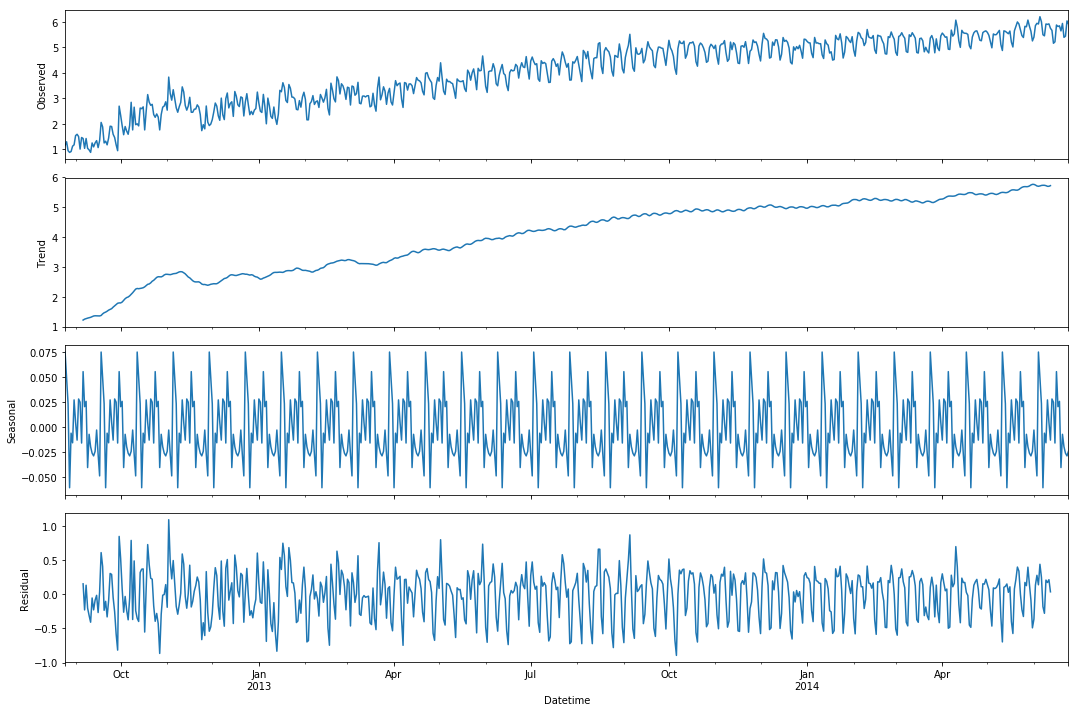

In [97]:
decomposition=sm.tsa.seasonal_decompose(train_log.dropna(),freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 
decomposition.plot()
plt.show()

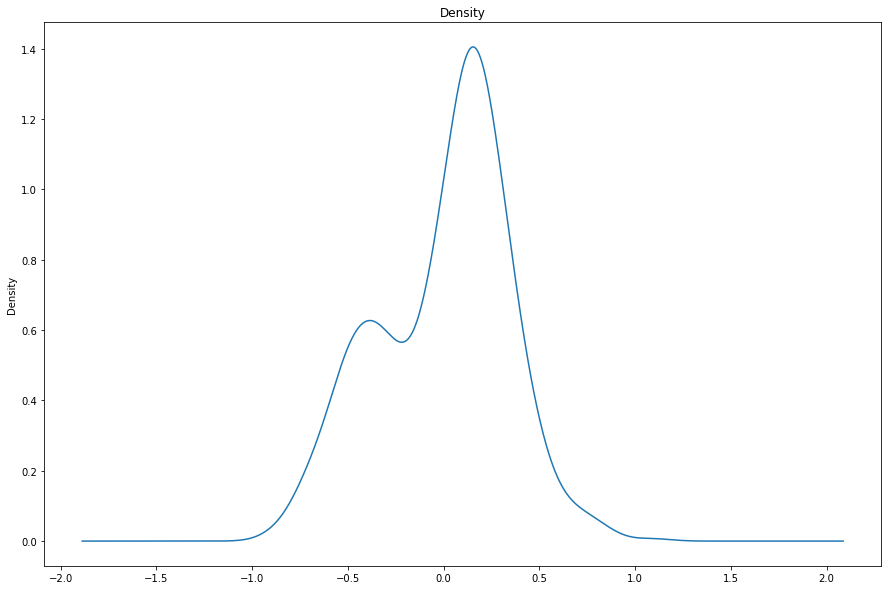

In [98]:
residual.plot(kind='kde', title='Density')

In [99]:
#training = training.iloc[1:]
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = training.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 

In [100]:
test_stationarity(train_log_decompose.Count)

Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [121]:
lag_acf = acf(train_log.diff().dropna(), nlags=25) 
lag_pacf = pacf(train_log.diff().dropna(), nlags=25, method='ols')

/home/abhishek/youtube_tutorial/JupyterYT/venv/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


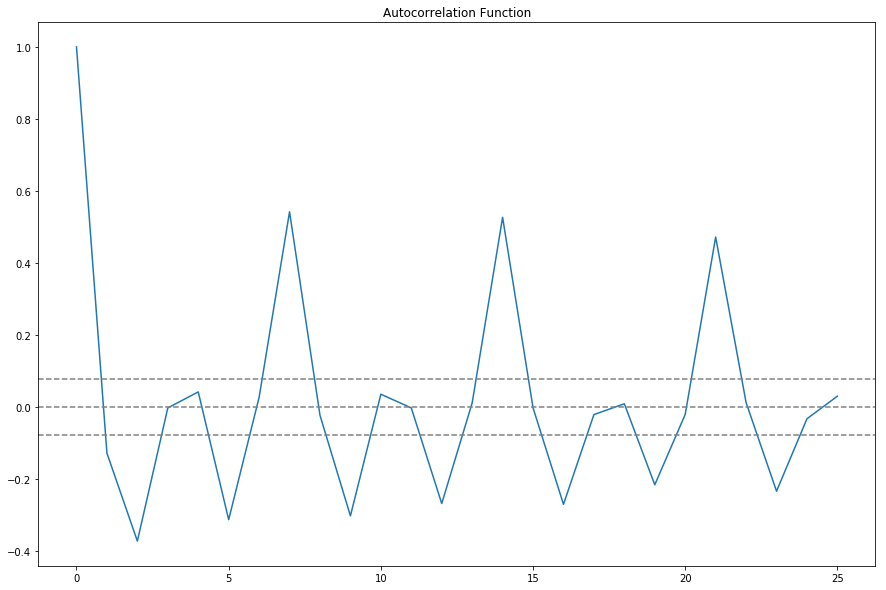

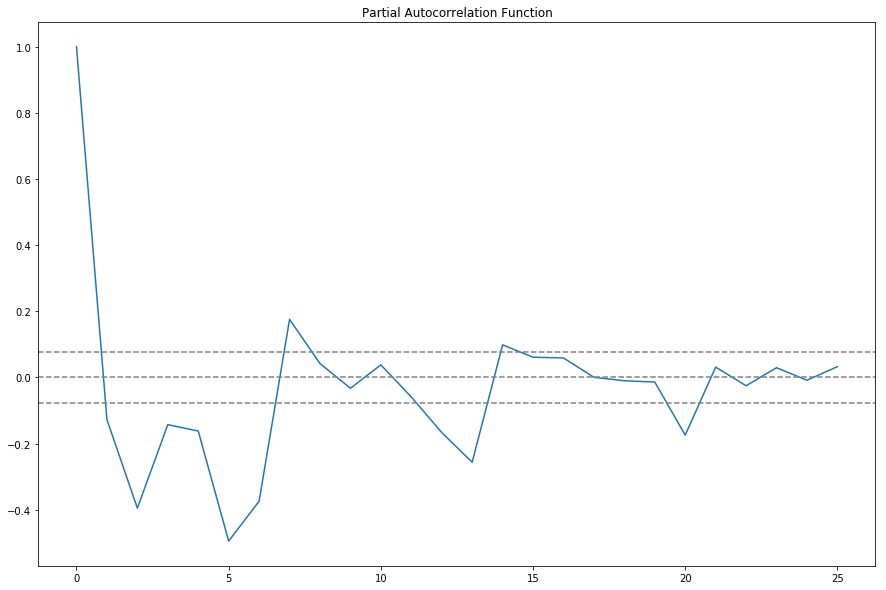

In [122]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray') 
plt.title('Autocorrelation Function')  
plt.show()
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

## From PACF plot p=1 || From ACF plot q=1

## AR Model

In [329]:
model = ARIMA(train_log, order=(1, 1, 0))  

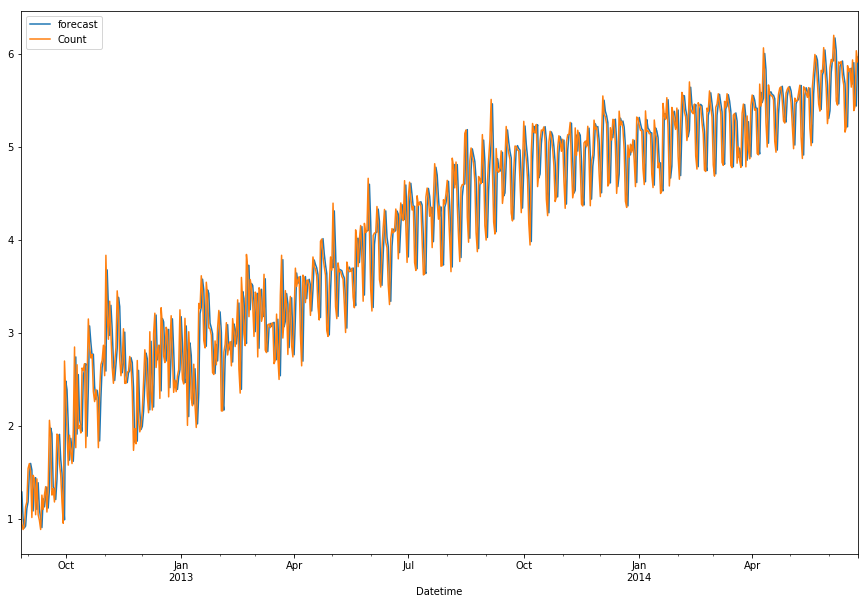

In [330]:
results_AR = model.fit(disp=-1)  
results_AR.plot_predict(dynamic=False)
plt.show()

In [331]:
ARfc,_,_ = results_AR.forecast(len(validating),alpha=0.05)

In [332]:
ARfc

array([5.94260678, 5.94768577, 5.955081  , 5.96218122, 5.96931902,
       5.97645203, 5.98358565, 5.9907192 , 5.99785275, 6.0049863 ,
       6.01211985, 6.0192534 , 6.02638696, 6.03352051, 6.04065406,
       6.04778761, 6.05492116, 6.06205472, 6.06918827, 6.07632182,
       6.08345537, 6.09058892, 6.09772248, 6.10485603, 6.11198958,
       6.11912313, 6.12625668, 6.13339024, 6.14052379, 6.14765734,
       6.15479089, 6.16192444, 6.169058  , 6.17619155, 6.1833251 ,
       6.19045865, 6.1975922 , 6.20472576, 6.21185931, 6.21899286,
       6.22612641, 6.23325996, 6.24039352, 6.24752707, 6.25466062,
       6.26179417, 6.26892772, 6.27606128, 6.28319483, 6.29032838,
       6.29746193, 6.30459548, 6.31172904, 6.31886259, 6.32599614,
       6.33312969, 6.34026324, 6.3473968 , 6.35453035, 6.3616639 ,
       6.36879745, 6.375931  , 6.38306456, 6.39019811, 6.39733166,
       6.40446521, 6.41159876, 6.41873232, 6.42586587, 6.43299942,
       6.44013297, 6.44726652, 6.45440008, 6.46153363, 6.46866

In [333]:
ARfc = np.exp(ARfc)

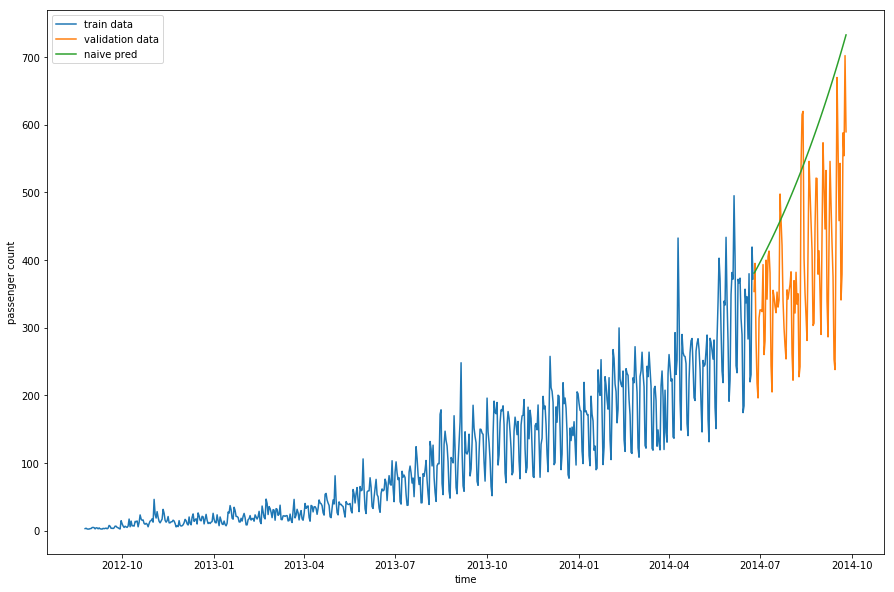

In [334]:
pred['AR'] = ARfc
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['AR'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','naive pred'])

In [335]:
rms = sqrt(mean_squared_error(validating.Count, ARfc)) 
print("RMS SCORE:",rms)

RMS SCORE: 181.3012293913222


## MA model

In [357]:
MA_model = ARIMA(train_log, order=(0, 1, 1))

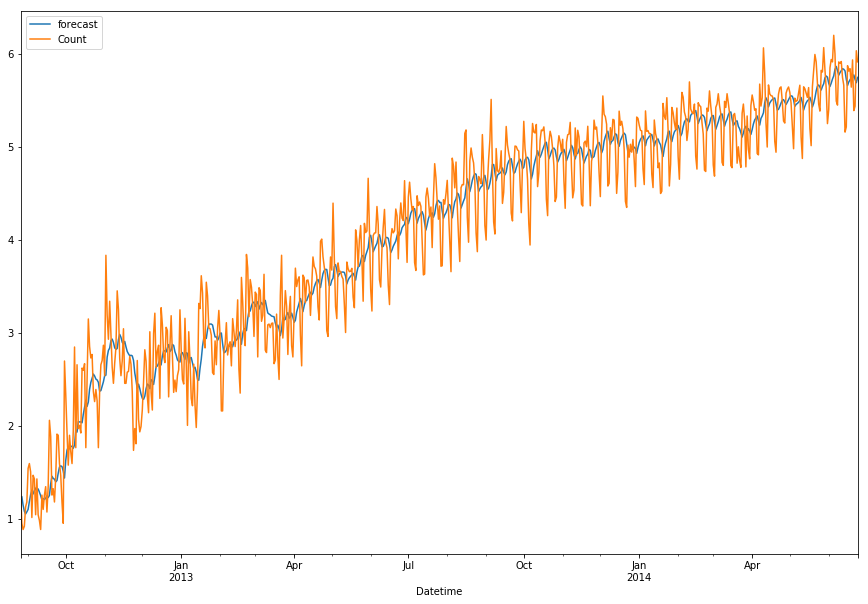

In [358]:
results_MA = MA_model.fit(disp=-1)  
results_MA.plot_predict(dynamic=False)
plt.show()

In [359]:
MAfc,_,_ = results_MA.forecast(len(validating))

In [360]:
np.exp(MAfc)

array([324.68967042, 326.95319301, 329.23249539, 331.52768757,
       333.83888031, 336.16618517, 338.50971447, 340.86958131,
       343.24589958, 345.63878398, 348.04835   , 350.47471393,
       352.91799286, 355.37830473, 357.85576828, 360.35050306,
       362.8626295 , 365.39226883, 367.93954313, 370.50457536,
       373.0874893 , 375.68840962, 378.30746184, 380.94477237,
       383.60046849, 386.27467837, 388.96753109, 391.6791566 ,
       394.40968578, 397.15925042, 399.9279832 , 402.71601777,
       405.52348868, 408.35053142, 411.19728245, 414.06387915,
       416.95045988, 419.85716395, 422.78413164, 425.73150423,
       428.69942395, 431.68803406, 434.69747879, 437.72790339,
       440.77945411, 443.85227823, 446.94652406, 450.06234094,
       453.19987924, 456.35929039, 459.54072687, 462.74434224,
       465.9702911 , 469.21872915, 472.48981318, 475.78370104,
       479.10055173, 482.44052532, 485.803783  , 489.1904871 ,
       492.60080107, 496.0348895 , 499.49291814, 502.97

In [356]:
rms = sqrt(mean_squared_error(validating.Count, np.exp(MAfc))) 
print("RMS SCORE:",rms)

RMS SCORE: 174.79667871382014


## ARIMA combined model

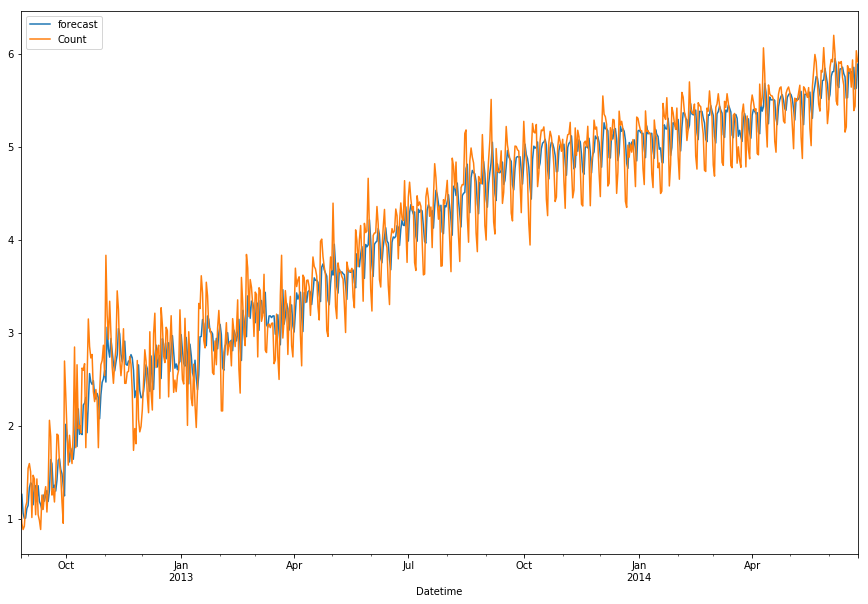

In [336]:
ARIMA_model = ARIMA(train_log, order=(1, 1, 1))  
results_ARIMA = ARIMA_model.fit(disp=-1)  
results_ARIMA.plot_predict(dynamic=False)
plt.show()

In [337]:
ARIMA_fc,_,_ = results_ARIMA.forecast(len(validating))

In [338]:
rms = sqrt(mean_squared_error(validating.Count, np.exp(ARIMA_fc)))
print("RMS SCORE:",rms)

RMS SCORE: 124.33131311920516


## Seasonal ARIMA

In [267]:
model=sm.tsa.statespace.SARIMAX(training.Count,order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 

/home/abhishek/youtube_tutorial/JupyterYT/venv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [272]:
pred['SARIMAX']=model.forecast(len(validating))

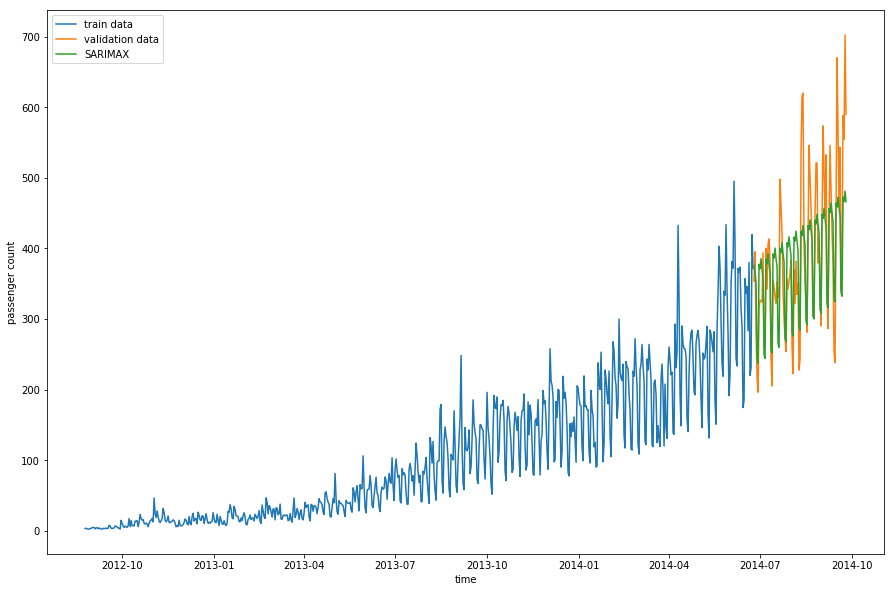

In [274]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['SARIMAX'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','SARIMAX'])

In [275]:
rms = sqrt(mean_squared_error(validating.Count, pred['SARIMAX'])) 
print("RMS SCORE:",rms)

RMS SCORE: 69.88508448051837
